# Part 1: Data Extraction

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Loading and Compiling Data

In [3]:
#importing data
#df = pd.read_csv('Combined_LCA_Disclosure_Data_FY2020_to_FY2024.csv', low_memory=False)
df2020 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2020.csv', low_memory=False)
df2021 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2021.csv', low_memory=False)
df2022 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2022.csv', low_memory=False)
df2023 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2023.csv', low_memory=False)
df2024 = pd.read_csv('Combined_LCA_Disclosure_Data_FY2024.csv', low_memory=False)
all_data = [df2020, df2021,df2022,df2023,df2024]

df = pd.concat(all_data)
df.head(5)

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,ORIGINAL_CERT_DATE,VISA_CLASS,JOB_TITLE,SOC_CODE,SOC_TITLE,FULL_TIME_POSITION,...,WILLFUL_VIOLATOR,SUPPORT_H1B,STATUTORY_BASIS,APPENDIX_A_ATTACHED,PUBLIC_DISCLOSURE,PREPARER_LAST_NAME,PREPARER_FIRST_NAME,PREPARER_MIDDLE_INITIAL,PREPARER_BUSINESS_NAME,PREPARER_EMAIL
0,I-200-19268-393467,Certified,2019-09-25,2019-10-01,NaN,H-1B,"APPLICATION ENGINEER, OMS [15-1199.02]",15-1199,"COMPUTER OCCUPATIONS, ALL OTHER",Y,...,N,NaN,NaN,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
1,I-200-19268-638983,Certified,2019-09-25,2019-10-01,NaN,H-1B,BI DEVELOPER II,15-1132,"SOFTWARE DEVELOPERS, APPLICATIONS",Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
2,I-200-19268-177184,Certified,2019-09-25,2019-10-01,NaN,H-1B,QUALITY ENGINEER,17-2141,MECHANICAL ENGINEERS,Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
3,I-200-19268-936403,Certified,2019-09-25,2019-10-01,NaN,H-1B,"SOFTWARE DEVELOPER, APPLICATIONS",15-1132,"SOFTWARE DEVELOPERS, APPLICATIONS",Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,NaN
4,I-200-19268-394079,Certified,2019-09-25,2019-10-01,NaN,H-1B,QUALITY ENGINEER LEVEL II,15-1199,"COMPUTER OCCUPATIONS, ALL OTHER",Y,...,N,Y,BOTH,NaN,Disclose Business,NaN,NaN,NaN,NaN,LEGAL@THEEGIANTS.COM


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3564698 entries, 0 to 890367
Data columns (total 96 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   CASE_NUMBER                     object 
 1   CASE_STATUS                     object 
 2   RECEIVED_DATE                   object 
 3   DECISION_DATE                   object 
 4   ORIGINAL_CERT_DATE              object 
 5   VISA_CLASS                      object 
 6   JOB_TITLE                       object 
 7   SOC_CODE                        object 
 8   SOC_TITLE                       object 
 9   FULL_TIME_POSITION              object 
 10  BEGIN_DATE                      object 
 11  END_DATE                        object 
 12  TOTAL_WORKER_POSITIONS          int64  
 13  NEW_EMPLOYMENT                  int64  
 14  CONTINUED_EMPLOYMENT            int64  
 15  CHANGE_PREVIOUS_EMPLOYMENT      int64  
 16  NEW_CONCURRENT_EMPLOYMENT       int64  
 17  CHANGE_EMPLOYER                 i

In [5]:
#selectdf["WORKSITE_WORKERS"] = selectdf["WORKSITE_WORKERS"].fillna(0).astype(int)
#selectdf.WORKSITE_WORKERS.value_counts()

In [6]:
# Delete previous dataframes to free memory
del df2020, df2021, df2022, df2023, df2024, all_data

### Find "ANNUAL_WAGE"

In [7]:
#Clean and convert salaries to numeric, handling outliers
unique_units = df['PW_UNIT_OF_PAY'].unique()
print(unique_units)

['Year' 'Hour' 'Bi-Weekly' nan 'Month' 'Week']


In [8]:
# Convert salaries to 'Year'
df['PREVAILING_WAGE'] = pd.to_numeric(df['PREVAILING_WAGE'], errors='coerce')
df = df[df['PREVAILING_WAGE'] > 0]  # Filter out non-positive values

conversion_factors = {
    'Year': 1,            # No Normalization
    'Month': 12,          # 12 months in a year
    'Bi-Weekly': 26,      # 26 bi-weekly periods in a year
    'Week': 52,           # 52 weeks in a year
    'Hour': 2080          # 52 weeks in a year x 40 hrs a week
}

df['ANNUAL_WAGE'] = df.apply(
    lambda row: row['PREVAILING_WAGE'] * conversion_factors.get(row['PW_UNIT_OF_PAY'], 1),
    axis=1
)

### Finding "Decision_Duration"

In [9]:
#get the processing time from subtracting decision date and start date and case status is certified
#processing the time into usable format
df['BEGIN_DATE'] = pd.to_datetime(df['BEGIN_DATE'])
df['DECISION_DATE'] = pd.to_datetime(df['DECISION_DATE'],errors='coerce')
df['RECEIVED_DATE'] = pd.to_datetime(df['RECEIVED_DATE'],errors='coerce')

df['Decision_Duration'] = np.abs((df['DECISION_DATE'] - df['RECEIVED_DATE']).dt.days)

print(df[['DECISION_DATE', 'RECEIVED_DATE', 'Decision_Duration']])

       DECISION_DATE RECEIVED_DATE  Decision_Duration
0         2019-10-01    2019-09-25                  6
1         2019-10-01    2019-09-25                  6
2         2019-10-01    2019-09-25                  6
3         2019-10-01    2019-09-25                  6
4         2019-10-01    2019-09-25                  6
...              ...           ...                ...
890363    2024-07-01    2023-10-19                256
890364    2024-07-01    2024-06-24                  7
890365    2024-07-01    2024-06-24                  7
890366    2024-07-01    2024-06-24                  7
890367    2024-07-01    2024-06-24                  7

[3562736 rows x 3 columns]


### Label Encoding Features

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3562736 entries, 0 to 890367
Data columns (total 98 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   CASE_NUMBER                     object        
 1   CASE_STATUS                     object        
 2   RECEIVED_DATE                   datetime64[ns]
 3   DECISION_DATE                   datetime64[ns]
 4   ORIGINAL_CERT_DATE              object        
 5   VISA_CLASS                      object        
 6   JOB_TITLE                       object        
 7   SOC_CODE                        object        
 8   SOC_TITLE                       object        
 9   FULL_TIME_POSITION              object        
 10  BEGIN_DATE                      datetime64[ns]
 11  END_DATE                        object        
 12  TOTAL_WORKER_POSITIONS          int64         
 13  NEW_EMPLOYMENT                  int64         
 14  CONTINUED_EMPLOYMENT            int64         
 15  CHAN

In [11]:
cat_columns = df.select_dtypes(include=['object']).columns
label_encoder= {}


for col in cat_columns:
    df[col] = df[col].astype(str)
    label_encoder[col] = LabelEncoder()
    df[col] = label_encoder[col].fit_transform(df[col])

### Finding Correlation Variables

#### Spearman Correlation

In [12]:
#spearman correlation
corr = df.corr(method='spearman')
corr_matrix = corr['CASE_STATUS']
print(corr_matrix.sort_values(ascending=False))

target_corr = corr['CASE_STATUS'].drop('CASE_STATUS').sort_values(ascending=False)

CASE_STATUS               1.000000
Decision_Duration         0.182314
EMPLOYER_POC_PHONE_EXT    0.088034
EMPLOYER_PHONE_EXT        0.073870
PREPARER_BUSINESS_NAME    0.058214
                            ...   
RECEIVED_DATE            -0.069258
BEGIN_DATE               -0.070944
PW_OTHER_YEAR            -0.080023
END_DATE                 -0.080831
ORIGINAL_CERT_DATE       -0.793554
Name: CASE_STATUS, Length: 98, dtype: float64


#### Pearson Correlation

In [13]:
#pearson correlation
pearson_corr = df.corr()
pearson_corr_matrix = pearson_corr['CASE_STATUS']
print(pearson_corr_matrix.sort_values(ascending=False))

target_pearcorr = pearson_corr['CASE_STATUS'].drop('CASE_STATUS').sort_values(ascending=False)

CASE_STATUS                     1.000000
Decision_Duration               0.303863
PREPARER_BUSINESS_NAME          0.051504
EMPLOYER_POC_EMAIL              0.040439
AGENT_ATTORNEY_EMAIL_ADDRESS    0.039796
                                  ...   
WAGE_UNIT_OF_PAY               -0.047105
PREVAILING_WAGE                -0.050950
END_DATE                       -0.052725
PW_OTHER_YEAR                  -0.053105
ORIGINAL_CERT_DATE             -0.401537
Name: CASE_STATUS, Length: 98, dtype: float64


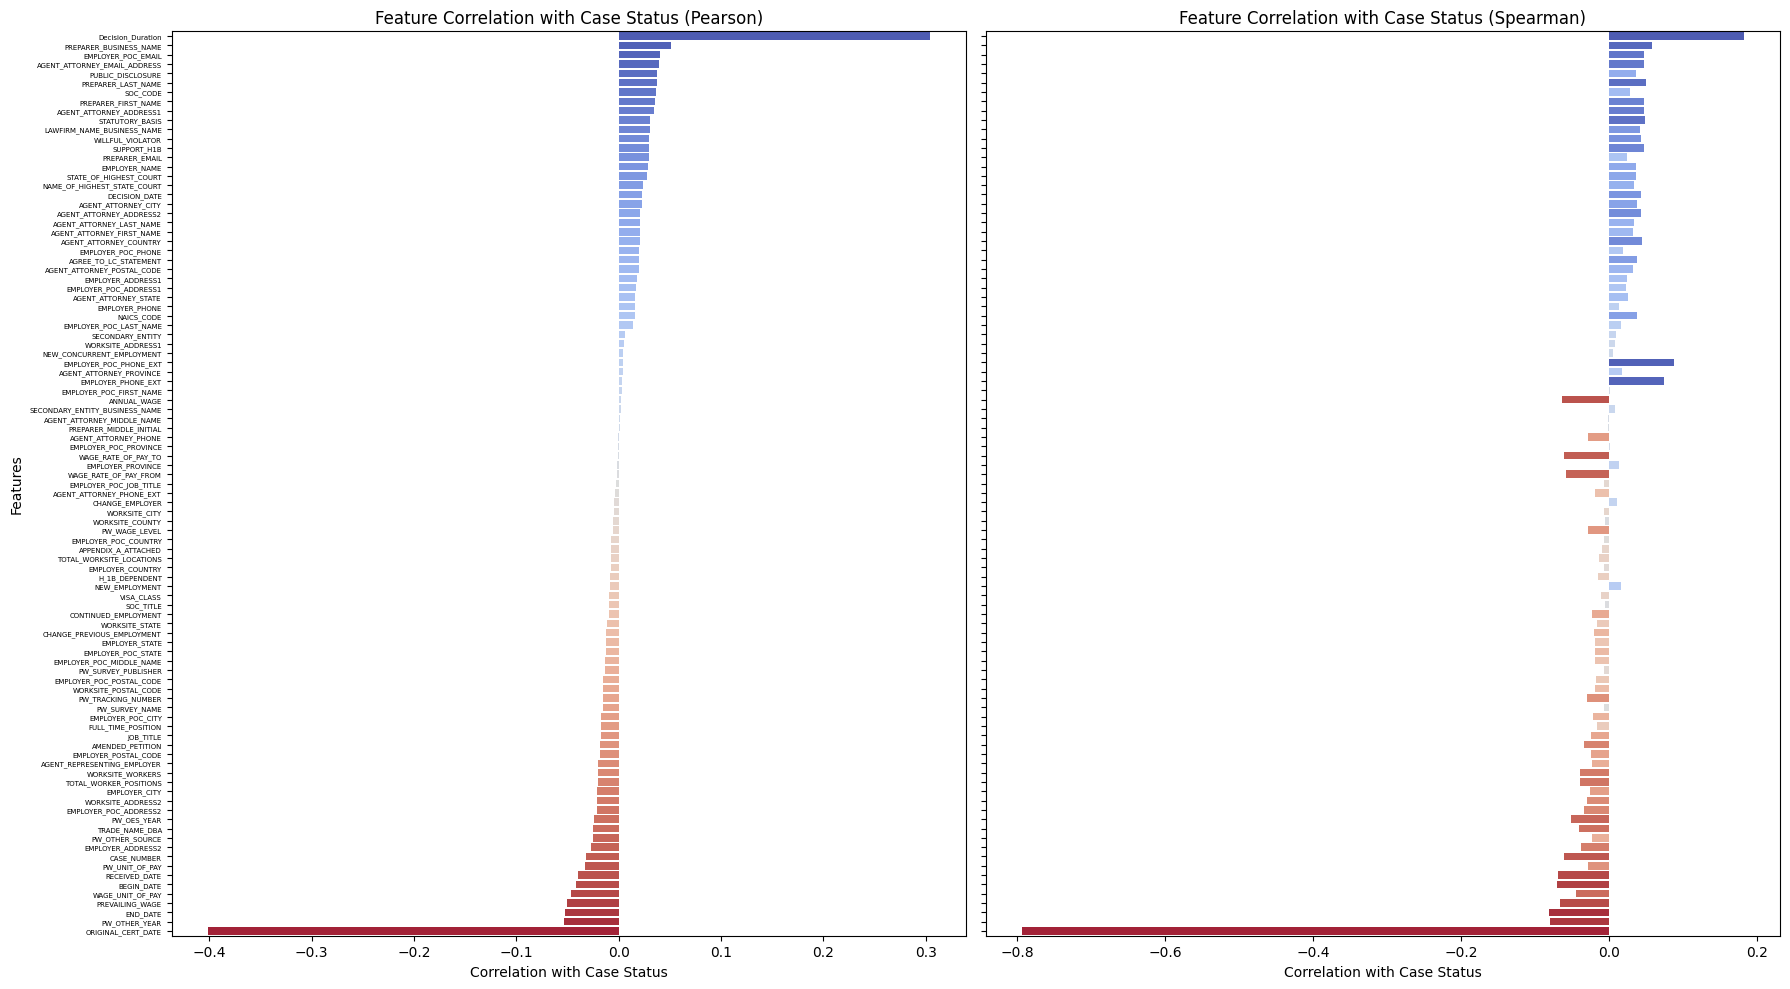

In [71]:
#side by side comparison of spearman and pearson
fig, axes = plt.subplots(1, 2, figsize=(18,10), sharey=True)

# Plot Pearson correlation
sns.barplot(x=target_pearcorr.values, y=target_pearcorr.index, palette="coolwarm", hue=target_pearcorr.index , ax=axes[0], legend=False)
axes[0].set_title("Feature Correlation with Case Status (Pearson)")
axes[0].set_xlabel("Correlation with Case Status")
axes[0].set_ylabel("Features")
axes[0].tick_params(axis='y', labelsize=5)  

# Plot Spearman correlation
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm", hue=target_corr.index, ax=axes[1], legend=False)
axes[1].set_title("Feature Correlation with Case Status (Spearman)")
axes[1].set_xlabel("Correlation with Case Status")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [15]:
'''
correlation_df = pd.DataFrame({
    "Pearson Correlation": target_pearcorr,
    "Spearman Correlation": target_corr
}).sort_values(by="Pearson Correlation", ascending=False)


pd.set_option('display.max_rows', None)
print(correlation_df)
'''

'\ncorrelation_df = pd.DataFrame({\n    "Pearson Correlation": target_pearcorr,\n    "Spearman Correlation": target_corr\n}).sort_values(by="Pearson Correlation", ascending=False)\n\n\npd.set_option(\'display.max_rows\', None)\nprint(correlation_df)\n'

#### Mutual Information Classification

In [16]:
#df['Decision_Duration'] = df['Decision_Duration'].dt.days
X = df.drop(columns=['CASE_STATUS'])
y = df['CASE_STATUS'] 
X['DECISION_DATE'] = X['DECISION_DATE'].astype('int64')
X['END_DATE'] = X['END_DATE'].astype('int64')
X['BEGIN_DATE'] = X['BEGIN_DATE'].astype('int64')
X['RECEIVED_DATE'] = X['RECEIVED_DATE'].astype('int64')

print(X.dtypes.value_counts())  
print(y.dtype)  

X=X.fillna(0)

mi_scores = mutual_info_classif(X, y, discrete_features=False)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by="Mutual Information Score", ascending=False)
print(mi_scores_df)

int64      86
float64    11
Name: count, dtype: int64
int64
                       Feature  Mutual Information Score
96           Decision_Duration                  0.322970
40       EMPLOYER_POC_PROVINCE                  0.265914
8           FULL_TIME_POSITION                  0.265300
82    TOTAL_WORKSITE_LOCATIONS                  0.246666
3           ORIGINAL_CERT_DATE                  0.240629
..                         ...                       ...
14  CHANGE_PREVIOUS_EMPLOYMENT                  0.002788
42      EMPLOYER_POC_PHONE_EXT                  0.001843
56    AGENT_ATTORNEY_PHONE_EXT                  0.001591
28          EMPLOYER_PHONE_EXT                  0.001087
15   NEW_CONCURRENT_EMPLOYMENT                  0.000282

[97 rows x 2 columns]


/var/folders/z0/qb5gklfx3495h7m28hm9r8lc0000gn/T/ipykernel_80731/4199317166.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores_df['Mutual Information Score'], y=mi_scores_df['Feature'], palette="viridis")


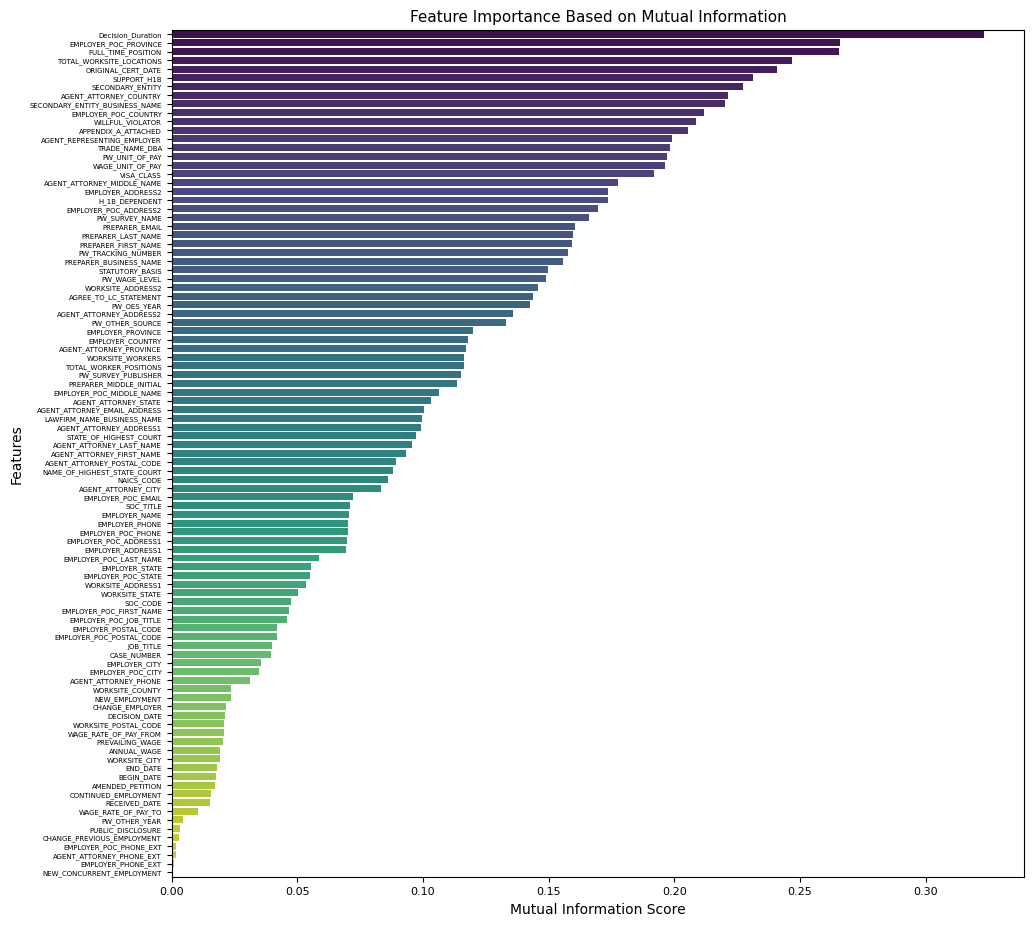

In [65]:
# Plot mutual information scores
plt.figure(figsize=(11, 11))
sns.barplot(x=mi_scores_df['Mutual Information Score'], y=mi_scores_df['Feature'], palette="viridis")
plt.xlabel("Mutual Information Score", fontsize=10)
plt.ylabel("Features", fontsize=10)
plt.title("Feature Importance Based on Mutual Information" ,fontsize=11)

plt.xticks(fontsize=8) 
plt.yticks(fontsize=5)  

plt.show()

In [18]:
correlation_df = pd.DataFrame({
    "Pearson Correlation": target_pearcorr,  
    "Spearman Correlation": target_corr,   
    "Mutual Information": mi_scores          
}, index=X.columns) 

# Sort the DataFrame by Pearson Correlation in descending order
correlation_df = correlation_df.sort_values(by="Pearson Correlation", ascending=False)

# display all rows
pd.set_option('display.max_rows', None)
print(correlation_df)

                                Pearson Correlation  Spearman Correlation  \
Decision_Duration                          0.303863              0.182314   
PREPARER_BUSINESS_NAME                     0.051504              0.058214   
EMPLOYER_POC_EMAIL                         0.040439              0.047846   
AGENT_ATTORNEY_EMAIL_ADDRESS               0.039796              0.047469   
PUBLIC_DISCLOSURE                          0.037609              0.035944   
PREPARER_LAST_NAME                         0.037375              0.050421   
SOC_CODE                                   0.036824              0.028268   
PREPARER_FIRST_NAME                        0.035254              0.046821   
AGENT_ATTORNEY_ADDRESS1                    0.034369              0.047229   
STATUTORY_BASIS                            0.030950              0.048229   
LAWFIRM_NAME_BUSINESS_NAME                 0.030848              0.041929   
WILLFUL_VIOLATOR                           0.029954              0.043096   

### Finding the most relevant factors

#### Top 15 Features from Spearman and Pearson Correlation

In [32]:
#top 15 pearson
top_15_pearson = correlation_df["Pearson Correlation"].abs().nlargest(15)
print("Top 15 Features Based on Pearson Correlation:")
print(top_15_pearson)

Top 15 Features Based on Pearson Correlation:
ORIGINAL_CERT_DATE              0.401537
Decision_Duration               0.303863
PW_OTHER_YEAR                   0.053105
END_DATE                        0.052725
PREPARER_BUSINESS_NAME          0.051504
PREVAILING_WAGE                 0.050950
WAGE_UNIT_OF_PAY                0.047105
BEGIN_DATE                      0.041723
EMPLOYER_POC_EMAIL              0.040439
RECEIVED_DATE                   0.039914
AGENT_ATTORNEY_EMAIL_ADDRESS    0.039796
PUBLIC_DISCLOSURE               0.037609
PREPARER_LAST_NAME              0.037375
SOC_CODE                        0.036824
PREPARER_FIRST_NAME             0.035254
Name: Pearson Correlation, dtype: float64


In [33]:
#top 15 spearman
top_15_spearman = correlation_df["Spearman Correlation"].abs().nlargest(15)
print("Top 15 Features Based on Spearman Correlation:")
print(top_15_spearman)

Top 15 Features Based on Spearman Correlation:
ORIGINAL_CERT_DATE        0.793554
Decision_Duration         0.182314
EMPLOYER_POC_PHONE_EXT    0.088034
END_DATE                  0.080831
PW_OTHER_YEAR             0.080023
EMPLOYER_PHONE_EXT        0.073870
BEGIN_DATE                0.070944
RECEIVED_DATE             0.069258
PREVAILING_WAGE           0.066165
ANNUAL_WAGE               0.063255
CASE_NUMBER               0.060797
WAGE_RATE_OF_PAY_TO       0.060461
WAGE_RATE_OF_PAY_FROM     0.058361
PREPARER_BUSINESS_NAME    0.058214
PW_OES_YEAR               0.051227
Name: Spearman Correlation, dtype: float64


In [41]:
#combined top 15 features
#Finding union - all unique features from both
combined_top_15 = pd.concat([top_15_pearson, top_15_spearman]).drop_duplicates()


# Displaying the combined top 15 features
print("Top 15 Features Based on Pearson and Spearman Correlation:")
print(combined_top_15)
print("\n")




Top 15 Features Based on Pearson and Spearman Correlation:
ORIGINAL_CERT_DATE              0.401537
Decision_Duration               0.303863
PW_OTHER_YEAR                   0.053105
END_DATE                        0.052725
PREPARER_BUSINESS_NAME          0.051504
PREVAILING_WAGE                 0.050950
WAGE_UNIT_OF_PAY                0.047105
BEGIN_DATE                      0.041723
EMPLOYER_POC_EMAIL              0.040439
RECEIVED_DATE                   0.039914
AGENT_ATTORNEY_EMAIL_ADDRESS    0.039796
PUBLIC_DISCLOSURE               0.037609
PREPARER_LAST_NAME              0.037375
SOC_CODE                        0.036824
PREPARER_FIRST_NAME             0.035254
ORIGINAL_CERT_DATE              0.793554
Decision_Duration               0.182314
EMPLOYER_POC_PHONE_EXT          0.088034
END_DATE                        0.080831
PW_OTHER_YEAR                   0.080023
EMPLOYER_PHONE_EXT              0.073870
BEGIN_DATE                      0.070944
RECEIVED_DATE                   0.06925

#### Finding Intersection Features from Top 40 of Each metric

In [23]:
#top 40 of each
top_40_pearson = correlation_df.reindex(correlation_df["Pearson Correlation"].abs().nlargest(40).index)
top_40_spearman = correlation_df.reindex(correlation_df["Spearman Correlation"].abs().nlargest(40).index)
top_40_mi = correlation_df.nlargest(40, "Mutual Information")



In [24]:
# Find the overlaps between the top 20 features from each metric
top_40_pearson_set = set(top_40_pearson.index)
top_40_spearman_set = set(top_40_spearman.index)
top_40_mi_set = set(top_40_mi.index)

# Find the intersection of all three sets
overlapping_features = top_40_pearson_set & top_40_spearman_set & top_40_mi_set

In [26]:
#find the overlap features and print
final_overlapping_df = correlation_df.loc[list(overlapping_features)]

final_overlapping_df

,Pearson Correlation,Spearman Correlation,Mutual Information
PW_OES_YEAR,-0.024374,-0.051227,0.142740
EMPLOYER_ADDRESS2,-0.026830,-0.038428,0.173471
AGENT_ATTORNEY_ADDRESS2,0.021197,0.043400,0.135732
TRADE_NAME_DBA,-0.024696,-0.040858,0.198408
TOTAL_WORKER_POSITIONS,-0.020257,-0.039636,0.116124
WILLFUL_VIOLATOR,0.029954,0.043096,0.208759
AGENT_ATTORNEY_COUNTRY,0.020409,0.045179,0.221208
SUPPORT_H1B,0.029718,0.046704,0.231102
WAGE_UNIT_OF_PAY,-0.047105,-0.044198,0.196334
ORIGINAL_CERT_DATE,-0.401537,-0.793554,0.240629


Here is the 16 features found from overlap or intersection of the top 40 in each metrics.